

 # DISCO 卷积（Discrete-Continuous Convolutions）



 本教程演示了**离散-连续（DISCO）卷积**，它是局部神经算子框架的核心构建模块。

 DISCO 卷积的核心优势和重要性体现在：



 - 学习数据中的局部模式（局部特征提取）

 - 同时支持等距网格和非结构化网格数据

 - 能够在不规则区域上实现高效计算

 - 搭建离散数据与连续数据表示之间的桥梁



 本教程将涵盖多种 DISCO 卷积类型，并展示它们在神经算子架构中的应用。





 ## 准备工作（环境搭建与模块导入）

In [1]:
# 导入操作系统相关模块，用于执行系统命令（如下载图片）
import os
# 导入PyTorch核心库，用于构建神经网络和张量计算
import torch
# 导入PyTorch神经网络模块，用于定义网络层和参数
import torch.nn as nn
# 导入numpy库，用于数值计算和数组处理
import numpy as np
# 导入数学工具库，用于基础数学运算
import math
# 导入functools中的partial，用于创建偏函数（固定部分函数参数）
from functools import partial

# 导入matplotlib的image模块，用于读取图像文件
from matplotlib import image

# 从torch_harmonics.quadrature导入正交权重计算相关函数
# 这些函数用于计算数值积分中的正交权重，是DISCO卷积归一化的关键
from torch_harmonics.quadrature import (
    legendre_gauss_weights,  # 勒让德-高斯正交权重
    lobatto_weights,         # 洛巴托正交权重
    clenshaw_curtiss_weights,# 克兰肖-柯蒂斯正交权重
)

# 导入matplotlib的pyplot模块，用于数据可视化（绘图）
import matplotlib.pyplot as plt

# 设置绘图的颜色映射方案为"inferno"（暖色调渐变，适合展示图像特征）
cmap = "inferno"
# 配置计算设备：优先使用GPU（cuda:0），若无GPU则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 从neuralop库的DISCO卷积模块导入四种核心卷积层
# 这些是实现离散-连续卷积的核心类
from neuralop.layers.discrete_continuous_convolution import (
    DiscreteContinuousConv2d,                # 2D 离散-连续卷积（通用网格）
    DiscreteContinuousConvTranspose2d,       # 2D 离散-连续转置卷积（通用网格）
    EquidistantDiscreteContinuousConv2d,     # 2D 离散-连续卷积（等距网格）
    EquidistantDiscreteContinuousConvTranspose2d,  # 2D 离散-连续转置卷积（等距网格）
)


尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages
尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages


 第一步：下载并加载示例图像（爱因斯坦头像）

图像分辨率为(480, 360)，黑白图像


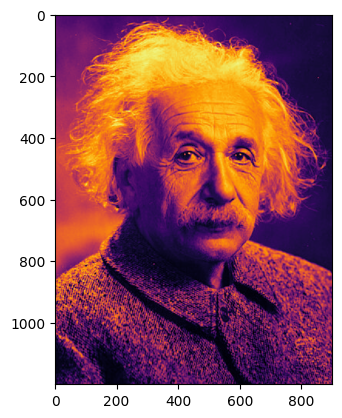

In [6]:
# 执行系统curl命令，从维基百科下载爱因斯坦头像图片并保存到本地（当前目录）
# -o 参数指定输出文件名为 ./einstein.jpg
# os.system(
#     "curl https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Albert_Einstein_Head.jpg/360px-Albert_Einstein_Head.jpg -o ./einstein.jpg"
# )

# 定义输入图像的目标分辨率（宽nx，高ny）
nx = 900
ny = 1200

# 读取本地保存的图像文件，返回numpy数组格式的图像数据
img = image.imread("D:/document/python/neural operators/layers/einstein.jpg")
print(f"图像分辨率为{img.shape}，黑白图像")  # 输出图像的原始形状以供参考
# 图像数据预处理：将numpy数组转换为PyTorch张量，并调整形状以满足网络输入要求
# 1. torch.from_numpy(img)：numpy数组转PyTorch张量
# 2. unsqueeze(0)：添加批次维度（第0维），此时形状为 [1, H, W]
# 3. unsqueeze(0)：添加通道维度（第0维），此时形状为 [1, 1, H, W]
# 4. interpolate(...)：图像插值缩放，将图像调整为 (ny, nx) 的分辨率
# 5. squeeze()：去除多余的批次和通道维度，返回形状为 [ny, nx] 的二维张量
data = nn.functional.interpolate(
    torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(ny, nx)
).squeeze()

# 绘制预处理后的图像，验证加载和缩放效果
plt.imshow(data, cmap=cmap)  # 使用指定的颜色映射方案显示图像
plt.show()  # 显示图像窗口


 第二步：创建输入数据对应的网格（DISCO卷积需要网格坐标信息）

In [ ]:
# 生成x轴方向的等距坐标点：从0到2，共nx个点
x_in = torch.linspace(0, 2, nx)
# 生成y轴方向的等距坐标点：从0到3，共ny个点
y_in = torch.linspace(0, 3, ny)

# 将一维坐标点转换为二维网格坐标（网格矩阵）
# indexing="ij"：使用矩阵索引方式（先行后列），生成的网格形状为 [nx, ny]
# 若使用indexing="xy"则为笛卡尔坐标方式（先列后行）
x_in, y_in = torch.meshgrid(x_in, y_in, indexing="ij")

# 构建输入网格的扁平化坐标矩阵：便于后续批量计算
# 1. reshape(-1)：将二维网格坐标展平为一维张量（所有网格点的坐标串联）
# 2. torch.stack(...)：将x和y方向的坐标堆叠，生成形状为 [2, nx*ny] 的张量
#    其中第0行是所有网格点的x坐标，第1行是所有网格点的y坐标
grid_in = torch.stack([x_in.reshape(-1), y_in.reshape(-1)])

# 计算输入网格的正交权重（QUADRATURE WEIGHTS）
# 【重要】这是DISCO卷积能够正确归一化的关键步骤，必须准确计算
# 正交权重用于数值积分，衡量每个网格点在卷积计算中的贡献权重
w_x = 2 * torch.ones_like(x_in) / nx  # x方向权重：定义域长度（2）均分至每个网格点
w_y = 3 * torch.ones_like(y_in) / ny  # y方向权重：定义域长度（3）均分至每个网格点
q_in = (w_x * w_y).reshape(-1)  # 每个网格点的总权重= x方向权重 * y方向权重，展平为一维张量


 可视化输入网格的分布（查看网格点的坐标位置）

In [ ]:
# 创建绘图窗口，指定窗口大小为 (4, 6)（宽4英寸，高6英寸）
plt.figure(
    figsize=(4, 6),
)
# 绘制散点图展示网格点分布，s=0.2设置散点大小（避免点重叠）
plt.scatter(grid_in[0], grid_in[1], s=0.2)
# 设置x轴坐标范围，与网格生成范围一致
plt.xlim(0, 2)
# 设置y轴坐标范围，与网格生成范围一致
plt.ylim(0, 3)
# 显示图像窗口
plt.show()


 第三步：调整输入数据格式，与网格坐标对应，并在网格上可视化数据

In [ ]:
# 数据形状和方向调整，使其与网格坐标一一对应
# 1. permute(1, 0)：维度交换，将形状从 [ny, nx] 转换为 [nx, ny]（匹配网格形状）
# 2. flip(1)：在第1维（y轴方向）翻转数据，调整图像方向以匹配网格坐标
# 3. reshape(-1)：展平为一维张量，形状为 [nx*ny]（与网格坐标张量形状对应）
data = data.permute(1, 0).flip(1).reshape(-1)

# 创建绘图窗口，指定窗口大小
plt.figure(figsize=(4,6))
# 绘制三角彩色图，将一维数据映射到二维网格上
# tripcolor：通过三角剖分将离散点数据转换为连续的彩色图像
plt.tripcolor(grid_in[0], grid_in[1], data, cmap=cmap)
# 设置x轴和y轴范围，与网格范围一致
plt.xlim(0, 2)
plt.ylim(0, 3)
# 显示图像窗口
plt.show()


 第四步：创建输出网格（DISCO卷积的输出结果将映射到该网格上）

In [ ]:
# 定义输出网格的分辨率（与输入网格一致，可根据需求调整）
nxo = 90
nyo = 120

# 生成输出网格x轴方向的等距坐标点：从0到2，共nxo个点
x_out = torch.linspace(0, 2, nxo)
# 生成输出网格y轴方向的等距坐标点：从0到3，共nyo个点
y_out = torch.linspace(0, 3, nyo)

# 将一维坐标转换为二维网格矩阵，indexing="ij"保持与输入网格一致的索引方式
x_out, y_out = torch.meshgrid(x_out, y_out, indexing="ij")

# 构建输出网格的扁平化坐标矩阵，格式与输入网格grid_in一致，形状为 [2, nxo*nyo]
grid_out = torch.stack([x_out.reshape(-1), y_out.reshape(-1)])

# 计算输出网格的正交权重，计算逻辑与输入网格完全一致
w_x = 2 * torch.ones_like(x_out) / nxo
w_y = 3 * torch.ones_like(y_out) / nyo
q_out = (w_x * w_y).reshape(-1)


 第五步：初始化通用网格DISCO卷积层，并配置边缘滤波器权重

 DISCO卷积的核心：通过局部核函数学习网格数据的局部特征

In [ ]:
# 初始化2D离散-连续卷积层（通用网格版本）
conv = DiscreteContinuousConv2d(
    1,  # 输入通道数：1（灰度图像，单通道）
    1,  # 输出通道数：1（保持单通道输出）
    grid_in=grid_in,  # 输入网格坐标矩阵
    grid_out=grid_out,  # 输出网格坐标矩阵
    quadrature_weights=q_in,  # 输入网格的正交权重（用于归一化）
    kernel_shape=[2, 4],  # 卷积核的形状参数
    radius_cutoff=5 / nyo,  # 核函数的截断半径（控制局部作用范围）
    periodic=False,  # 是否启用周期性边界条件（此处禁用，适用于非周期图像数据）
).float()  # 将卷积层参数转换为float32类型，适配常规张量计算

# 初始化卷积核权重，构建一个简易的边缘滤波器（类似有限差分算子）
# 边缘滤波器的作用：检测图像中的边缘特征（明暗突变区域）
w = torch.zeros_like(conv.weight)  # 创建与卷积核权重形状相同的全零张量
w[0, 0, 1] = 1.0   # 权重赋值：第1个位置设为1
w[0, 0, 3] = -1.0  # 权重赋值：第3个位置设为-1（通过差值检测边缘）
conv.weight = nn.Parameter(w)  # 将自定义权重转换为PyTorch可训练参数，赋值给卷积层

# 获取卷积层的局部滤波器矩阵（用于后续可视化，展示核函数的局部作用模式）
psi = conv.get_local_filter_matrix()


 第六步：执行DISCO卷积前向传播，获取输出结果并可视化

 注意：DISCO卷积要求输入数据形状为 [batch_size, n_channels, n_grid_points]

In [ ]:
# 调整输入数据形状，满足DISCO卷积的输入要求
# 原数据形状为 [nx*ny]，reshape后为 [1, 1, nx*ny]（批次大小=1，通道数=1，网格点数=nx*ny）
out = conv(data.reshape(1, 1, -1))

# 打印输出结果的形状，验证卷积前向传播是否成功
print(out.shape)

# 创建绘图窗口，指定窗口大小
plt.figure(figsize=(4,6))
# 处理输出结果并可视化：
# 1. squeeze()：去除批次和通道维度，得到形状为 [nxo*nyo] 的一维张量
# 2. detach()：分离张量从计算图中，避免影响后续梯度计算（仅用于可视化）
# 3. reshape(nxo, nyo)：将一维张量恢复为二维网格形状 [nxo, nyo]
# 4. transpose(0,1)：维度交换，调整图像宽高顺序以匹配可视化要求
# 5. flip(dims=(-2, ))：在倒数第二维翻转，调整图像方向以正确显示
# 6. imshow()：显示处理后的卷积输出结果
plt.imshow(torch.flip(out.squeeze().detach().reshape(nxo, nyo).transpose(0,1), dims=(-2, )), cmap=cmap)
plt.colorbar()  # 添加颜色条，展示数值与颜色的对应关系
plt.show()  # 显示图像窗口

# 保存卷积输出结果，用于后续对比（可选）
out1 = torch.flip(out.squeeze().detach().reshape(nxo, nyo).transpose(0, 1), dims=(-2,))


 第七步：初始化等距网格DISCO卷积层，重复边缘检测实验

 等距网格版本的DISCO卷积：针对规则等距网格优化，计算效率更高

In [ ]:
conv_equi = EquidistantDiscreteContinuousConv2d(
    1,  # 输入通道数：1
    1,  # 输出通道数：1
    (nx, ny),  # 输入网格的分辨率（无需传入具体坐标，仅需分辨率，等距网格的优势）
    (nxo, nyo),  # 输出网格的分辨率
    kernel_shape=[2, 4],  # 卷积核形状参数（与通用网格版本一致）
    radius_cutoff=5 / nyo,  # 核函数截断半径（与通用网格版本一致）
    domain_length=[2, 3],  # 网格的定义域长度（x轴：2，y轴：3，与之前网格范围一致）
)

# 初始化等距网格卷积层的权重，与通用网格版本使用相同的边缘滤波器
w = torch.zeros_like(conv.weight)
w[0, 0, 1] = 1.0
w[0, 0, 3] = -1.0
conv_equi.weight = nn.Parameter(w)

# 重新加载并预处理图像数据，转换为float32类型（适配等距网格卷积层）
data = nn.functional.interpolate(
    torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(ny, nx)
).float()

# 执行等距网格DISCO卷积前向传播
out_equi = conv_equi(data)

# 打印输出结果形状，验证卷积效果
print(out_equi.shape)

# 可视化等距网格卷积的输出结果
plt.figure(figsize=(4,6))
plt.imshow(out_equi.squeeze().detach(), cmap=cmap)
plt.colorbar()
plt.show()

# 保存等距网格卷积的输出结果，用于后续对比（可选）
out2 = out_equi.squeeze().detach()

# 打印输出结果形状，验证数据维度
print(out2.shape)


 第八步：可视化等距网格DISCO卷积的局部滤波器矩阵

 滤波器矩阵展示了卷积核对每个网格点的局部作用权重分布

In [ ]:
plt.figure(figsize=(4,6))
# 提取第0个通道的滤波器矩阵，分离计算图后可视化
plt.imshow(conv_equi.get_local_filter_matrix()[0].detach(), cmap=cmap)
plt.colorbar()  # 添加颜色条，展示权重数值分布


 第九步：测试通用网格DISCO转置卷积（上采样/反卷积）

 转置卷积的作用：将低分辨率特征图恢复为高分辨率，常用于图像重建

In [ ]:
convt = DiscreteContinuousConvTranspose2d(
    1,  # 输入通道数：1
    1,  # 输出通道数：1
    grid_in=grid_out,  # 输入网格（使用之前的输出网格grid_out）
    grid_out=grid_in,  # 输出网格（使用之前的输入网格grid_in）
    quadrature_weights=q_out,  # 输入网格的正交权重（使用q_out）
    kernel_shape=[2, 4],  # 转置卷积核形状参数
    radius_cutoff=3 / nyo,  # 核函数截断半径（缩小，提升局部性）
    periodic=False,  # 禁用周期性边界条件
).float()  # 转换为float32类型

# 初始化转置卷积核权重，构建一个平坦滤波器（平均加权，用于平滑重建）
w = torch.zeros_like(conv.weight)
w[0, 0, 0] = 1.0
w[0, 0, 1] = 1.0
w[0, 0, 2] = 1.0
w[0, 0, 3] = 1.0
convt.weight = nn.Parameter(w)

# 重新加载并预处理图像数据，适配转置卷积的输入要求
data = (
    nn.functional.interpolate(
        torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(ny, nx)
    )
    .squeeze().float()  # 去除多余维度并转换为float32类型
    .permute(1, 0).flip(1).reshape(-1)  # 调整形状和方向，匹配网格坐标
)

# 执行通用网格DISCO转置卷积前向传播
out = convt(data.reshape(1, 1, -1))

# 打印输出结果形状，验证转置卷积效果
print(out.shape)

# 可视化转置卷积的输出结果
plt.figure(figsize=(4,6))
plt.imshow(torch.flip(out.squeeze().detach().reshape(nx, ny).transpose(0,1), dims=(-2, )), cmap=cmap)
plt.colorbar()
plt.show()


 第十步：测试等距网格DISCO转置卷积，验证上采样/重建效果

In [ ]:
convt_equi = EquidistantDiscreteContinuousConvTranspose2d(
    1,  # 输入通道数：1
    1,  # 输出通道数：1
    (nxo, nyo),  # 输入网格分辨率
    (nx, ny),  # 输出网格分辨率
    kernel_shape=[2, 4],  # 转置卷积核形状参数
    radius_cutoff=3 / nyo,  # 核函数截断半径
    domain_length=[2, 3],  # 网格定义域长度
)

# 初始化等距网格转置卷积核权重，使用与通用网格版本相同的平坦滤波器
w = torch.zeros_like(convt_equi.weight)
w[0, 0, 0] = 1.0
w[0, 0, 1] = 1.0
w[0, 0, 2] = 1.0
w[0, 0, 3] = 1.0
convt_equi.weight = nn.Parameter(w)

# 重新加载并预处理图像数据，适配等距网格转置卷积的输入要求
data = nn.functional.interpolate(
    torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(nyo, nxo)
).float()

# 执行等距网格DISCO转置卷积前向传播
out_equi = convt_equi(data)

# 打印输出结果形状，验证转置卷积效果
print(out_equi.shape)

# 可视化等距网格转置卷积的输出结果
plt.figure(figsize=(4,6))
plt.imshow(out_equi.squeeze().detach(), cmap=cmap)
plt.colorbar()
plt.show()